In [1]:
# Imports
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LeakyReLU
import numpy as np
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, jaccard_score


## Inception V3 ##

### Data Loading and Transformations ###

In [2]:
# Data load
train_data_dir = 'Preprocessed_Data_2/train'
test_data_dir = 'Preprocessed_Data_2/test'
img_width, img_height = 299, 299
batch_size = 16  # Decreased batch size
num_classes = 3

In [3]:
# Data Augmentation and Normalization for Training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Added rotation
    width_shift_range=0.1,  # Added width shift
    height_shift_range=0.1  # Added height shift
)

# Normalization for Testing
test_datagen = ImageDataGenerator(rescale=1.0 / 255) #Don't use  everything used in train_datagen to avoid noise.

In [4]:
# Load and Augment Training Data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load Test Data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


### Model Architecture ###

In [6]:
# Model architecture with additional optimizations
def InceptionV3():
    model = Sequential()

    # Stem with Leaky ReLU and L2 regularization
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_regularizer=l2(0.001), input_shape=(299, 299, 3)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Inception Module A with Leaky ReLU
    model.add(Conv2D(64, kernel_size=(1, 1), kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU
    model.add(Conv2D(64, kernel_size=(3, 3), kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU
    model.add(Conv2D(64, kernel_size=(3, 3), kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU

    # Inception Module B with Leaky ReLU
    model.add(Conv2D(128, kernel_size=(1, 1), kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU
    model.add(Conv2D(128, kernel_size=(1, 7), kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU
    model.add(Conv2D(128, kernel_size=(7, 1), kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU
    model.add(Conv2D(128, kernel_size=(3, 3), kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU

    # Inception Module C with Leaky ReLU
    model.add(Conv2D(256, kernel_size=(1, 1), kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(2, 2), kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU

    # Flatten and fully connected layers with dropout
    model.add(AveragePooling2D(pool_size=(8, 8)))
    model.add(Flatten())
    model.add(Dropout(0.5))  # Added dropout
    model.add(Dense(3, activation='softmax'))  # Output layer with 3 units

    return model

In [7]:
# Create the Inception v3 model with 3 output classes
inception_v3_model = InceptionV3()

# Display model summary
inception_v3_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 149, 149, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 149, 149, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 149, 149, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 147, 147, 32)      0         
                                                                 
 batch_normalization_1 (Bat  (None, 147, 147, 32)      128       
 chNormalization)                                     

### Model Training ###

In [8]:
# Train with SGD optimizer, momentum, and adjusted learning rate
inception_v3_model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),  # Stochastic gradient descent with momentum
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']  # Additional metrics
)

In [9]:
# Increase the number of epochs
epochs = 30  # Increased epochs

# Fit the model with reduced overfitting
history = inception_v3_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
)

Epoch 1/30


322/322 [==============================] - 532s 2s/step - loss: 1.7653 - accuracy: 0.6995 - precision: 0.7155 - recall: 0.6538 - val_loss: 1.4263 - val_accuracy: 0.8222 - val_precision: 0.8478 - val_recall: 0.7911
Epoch 2/30
322/322 [==============================] - 469s 1s/step - loss: 1.4883 - accuracy: 0.7648 - precision: 0.7846 - recall: 0.7372 - val_loss: 1.7271 - val_accuracy: 0.5924 - val_precision: 0.6225 - val_recall: 0.5365
Epoch 3/30
322/322 [==============================] - 509s 2s/step - loss: 1.3248 - accuracy: 0.7912 - precision: 0.8065 - recall: 0.7698 - val_loss: 1.5979 - val_accuracy: 0.6514 - val_precision: 0.8635 - val_recall: 0.3144
Epoch 4/30
322/322 [==============================] - 496s 2s/step - loss: 1.2000 - accuracy: 0.8073 - precision: 0.8212 - recall: 0.7922 - val_loss: 1.1700 - val_accuracy: 0.8005 - val_precision: 0.8106 - val_recall: 0.7811
Epoch 5/30
322/322 [==============================] - 468s 1s/step - loss: 1.0652 - accuracy: 0.83

save the trained model

In [14]:
inception_v3_model.save('InceptionV3_optimized_model')

INFO:tensorflow:Assets written to: InceptionV3_optimized_model\assets


INFO:tensorflow:Assets written to: InceptionV3_optimized_model\assets


### Training Visualizations ###

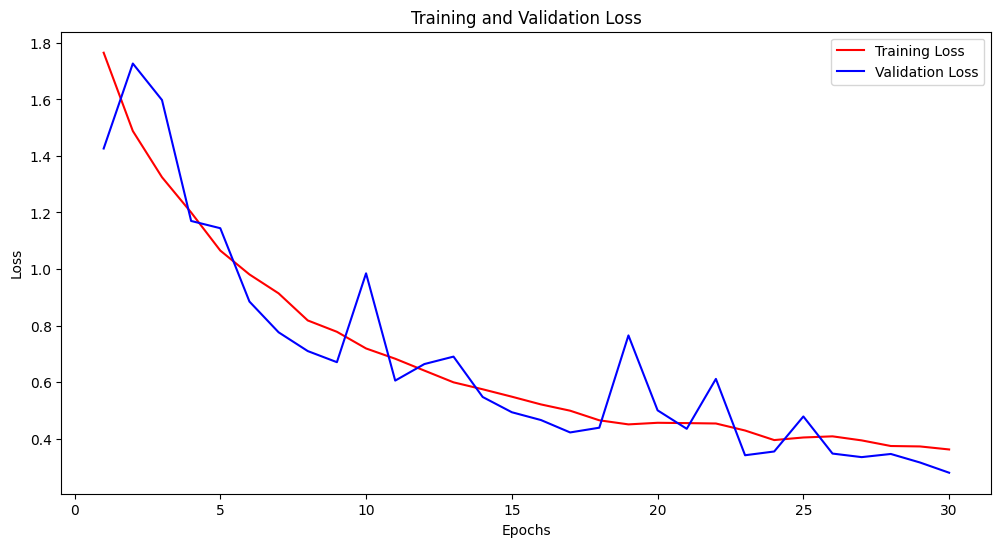

In [15]:
# Retrieve a list of training and validation losses and accuracies
train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Number of epochs
epochs_range = range(1, epochs + 1)

# Create the plots for training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, 'r', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

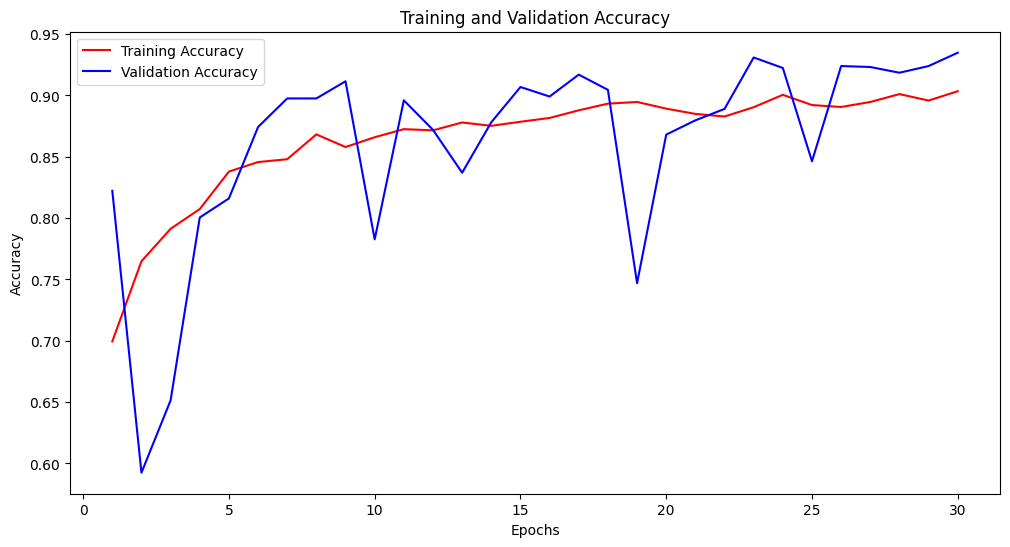

In [16]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create the plots for training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [5]:
loaded_inceptionV3_optimized = load_model("D:\8th_semester\DL\DL_Project\models\InceptionV3_optimized_model")

### Predict, Test and Evaluate the Model ###

In [25]:
# Test the Model
test_loss, test_accuracy, precision, recall = loaded_inceptionV3_optimized.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Precision : ",precision)
print("Recall : ",recall)


# Predict
y_true = test_generator.classes
y_pred = loaded_inceptionV3_optimized.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
print("Predicted Classes = " ,y_pred_classes)


#Evaluate the Model
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(confusion_mat)

81/81 [==============================] - 25s 304ms/step - loss: 0.2791 - accuracy: 0.9348 - precision: 0.9368 - recall: 0.9325
Test Loss: 0.2790686786174774
Test Accuracy: 0.9347826242446899
Precision :  0.936817467212677
Recall :  0.9324533939361572
81/81 [==============================] - 28s 345ms/step
Predicted Classes =  [0 1 2 ... 0 2 2]
Classification Report:
               precision    recall  f1-score   support

  COVID19_RGB       0.13      0.12      0.12       116
   NORMAL_RGB       0.27      0.27      0.27       317
PNEUMONIA_RGB       0.69      0.69      0.69       855

     accuracy                           0.54      1288
    macro avg       0.36      0.36      0.36      1288
 weighted avg       0.54      0.54      0.54      1288

Confusion Matrix:
[[ 14  39  63]
 [ 26  87 204]
 [ 71 192 592]]


In [24]:

# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes)

print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("F1-Score for each class:", f1_score)

# Calculate Jaccard Score for each class
jaccard_scores = jaccard_score(y_true, y_pred_classes, average=None)
print("Jaccard Score for each class:", jaccard_scores)

# Calculate Type 1 error and Type 2 error for each class
# Type 1 error (False Positives) - how many times a class was predicted but shouldn't have been
type_1_errors = confusion_mat.sum(axis=0) - np.diag(confusion_mat)  # Column-wise sum minus the diagonal

# Type 2 error (False Negatives) - how many times a class wasn't predicted but should have been
type_2_errors = confusion_mat.sum(axis=1) - np.diag(confusion_mat)  # Row-wise sum minus the diagonal

print("Type 1 Errors for each class:", type_1_errors)
print("Type 2 Errors for each class:", type_2_errors)

Precision for each class: [0.14414414 0.27044025 0.66123399]
Recall for each class: [0.13793103 0.27129338 0.66432749]
F1-Score for each class: [0.14096916 0.27086614 0.66277713]
Jaccard Score for each class: [0.07582938 0.15664845 0.495637  ]
Type 1 Errors for each class: [ 95 232 291]
Type 2 Errors for each class: [100 231 287]


In [6]:
#class to index mapping
print("Class Indices:", train_generator.class_indices)

Class Indices: {'COVID19_RGB': 0, 'NORMAL_RGB': 1, 'PNEUMONIA_RGB': 2}


### New Image Class Prediction ###

In [7]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# Load and preprocess the test image
img_path = 'test_image.jpg'  
img_width, img_height = 299, 299 
image = load_img(img_path, target_size=(img_width, img_height)) 
image_array = img_to_array(image)  # Convert the image to an array
image_array = image_array / 255.0  # Normalize the image
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

In [9]:
# Make a prediction
prediction = loaded_inceptionV3_optimized.predict(image_array)

# Get the class with the highest probability
predicted_class = np.argmax(prediction)
print(predicted_class)
if (predicted_class == 0):
    print("COVID 19")
elif(predicted_class == 1):
    print("Normal")
else:
    print("Pneumonia")

1/1 [==============================] - 0s 141ms/step
0
COVID 19
